# Image Processing in Python

## A concrete application in histopathology

#### Quentin Caudron

## What is histopathology ?

> Histopathology is the microscopic examination of tissue samples (from biopsies), to study manifestations of disease.

&mdash; Wikipedia

<img src="talk/histopathology.jpg" width="800px" />

### Preparation of tissue samples

The tissue is *processed* by embedding in paraffin wax, microtomy, and staining with dyes.

<img src="talk/histopathology_prep.jpg" width="800px" />

### Traditional histopathological analysis often relies on scores

<img src="talk/experiment.jpg" width="800px" />

### Computer-aided diagnosis - improving the manual process

<img src="talk/cad_intro.jpg" width="800px" />

### Computer-aided diagnosis - automatic cell counting and contour extraction

<img src="talk/cad.jpg" width="800px" />

### Computer-aided diagnosis - tissue segmentation

<img src="talk/cad2.jpg" width="800px" />

## Application - liver in Soay sheep

<img src="talk/soaysheep.jpg" width="800px" />

### Liver structure

<img src="talk/liver.jpg" width="700px" />

### Measuring levels of fibrosis, traditionally

<img src="talk/ishak.png" width="700px" />

### The problem - quantifying the extent of inflammation

<img src="talk/widefield_human_mask.jpg" width="900px" />

### Human labelling is slow and error-prone

<img src="talk/operator_comparison.jpg" width="800px" />

## A traditional image processing approach

We're going to pull primarily from [scikit-image](http://scikit-image.org), a fantastic Python library for image processing. 

We'll also use parts of [scipy](https://www.scipy.org/)'s `ndimage` module.

Much like in other areas of traditional machine learning, a lot of image processing is about *feature engineering*, representing the information you have in a way that is more digestable and processable by a computer. Feature engineering is as much art as science.

In [2]:
import numpy as np
from scipy.ndimage import maximum_filter, binary_fill_holes, distance_transform_edt, label
from skimage import io, morphology, filters, exposure, color, transform, measure, feature, img_as_float
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# Colour deconvolution matrix
colour_deconv_matrix = np.linalg.inv([
    [.26451728, .5205347, .81183386],
    [.9199094, .29797825, .25489032],
    [.28947765, .80015373, .5253158]
])

# Plot images in a single figure
def plot_image(image, titles=None):
    
    image = image
    
    # When provided a single-channel image, ensure scaling and plot it as-is
    if len(image.shape) == 2:
        
        # Rescale the image if needed
        image = image.astype(float)
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(5, 5))
        io.imshow(image)
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        plt.tight_layout()
        
    # When provided with a 3-channel image, plot the original, then separate the channels
    if len(image.shape) == 3 and image.shape[2] == 3:

        # Rescale the image if needed
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 4, 1)
        io.imshow(image)
        plt.title("All channels")
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for i in range(3):
            
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
                
            plt.subplot(1, 4, i+2)
            io.imshow(channel)
            plt.title("Channel {}".format(i+1))
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()

    # When provided with an N-channel image, plot the first three channels as RGB and the rest separately
    elif len(image.shape) == 3 and image.shape[2] > 3:
        
        n_channels = image.shape[2]
    
        # Rescale the images if needed
        main_image = image[:, :, :3]
        channels = []
        
        if main_image.max() > 1 or main_image.min() < 0:
            main_image -= main_image.min()
            main_image /= main_image.max()
            
        for i in range(3, n_channels):
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
            channels.append(channel)
                
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, n_channels-2, 1)
        io.imshow(main_image)
        if titles:
            plt.title(titles[0])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for idx, channel in enumerate(channels):
            plt.subplot(1, n_channels-2, idx+2)
            io.imshow(channel)
            if titles:
                plt.title(titles[idx+1])
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()
        
def plot_grid(images, titles):
    
    plt.figure(figsize=(14, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        io.imshow(images[i])
        plt.title(titles[i])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        
    plt.tight_layout()

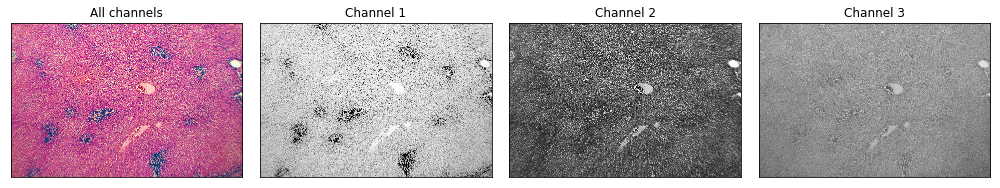

In [3]:
# Load the data, and look for a hint of where to start first
widefield_image_file = "data/Sheep11-4x-77.jpg"
image = transform.rescale(io.imread(widefield_image_file), 0.25)

plot_image(image)

The first channel is potentially promising, but those veins might cause issues. Instead of thinking about this in terms of RGB, maybe we can break the image up into its dyes : haematoxylin and eosin.

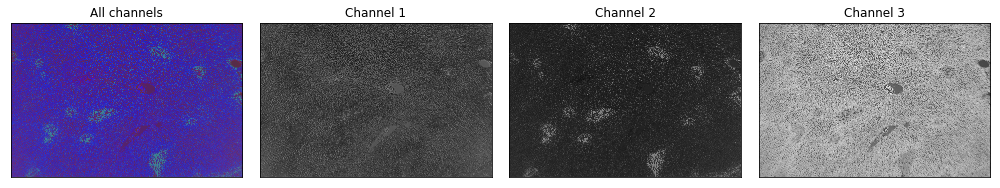

In [4]:
# Perform a colour deconvolution
heu = color.separate_stains(image, colour_deconv_matrix).astype(float)

plot_image(heu)

The middle channel here looks like a good start. Let's boost the contrast and improve our dynamic range using histogram equalisation.

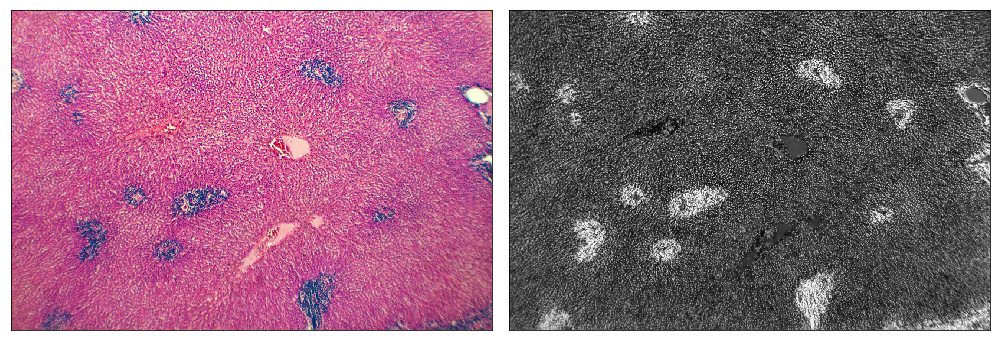

In [5]:
# Apply CLAHE on the haematoxylin channel
rescaled = exposure.rescale_intensity(heu[:, :, 1], out_range=(0, 1))
equalised_hist = exposure.equalize_adapthist(rescaled)

plot_image(np.dstack((image, equalised_hist)))

Haematoxylin dyes nuclei - and zones of inflammation of just high concentrations of cells, each of which contain a nucleus. We can now pretty easily pick out the zones of inflammation. Still, we need to differentiate between the inflammation and the background, which also contains lots of nuclei.

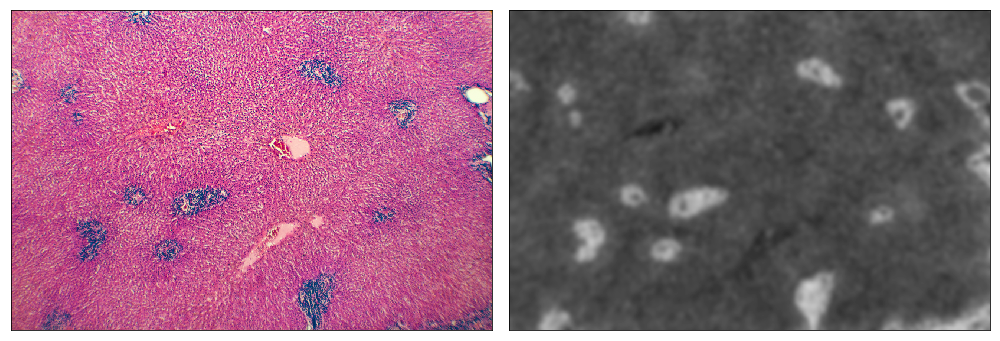

In [6]:
# Apply Gaussian blur
blurred = filters.gaussian(equalised_hist, 7)

plot_image(np.dstack((image, blurred)))

Applying a blur helped to even things out a little. We're at a point where the inflammation is quite bright, and the background is a medium grey. Let's crank up the contrast to stretch our dynamic range a little.

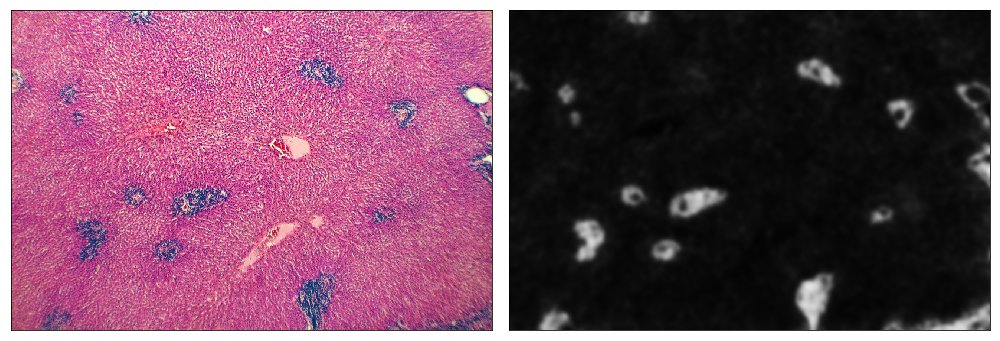

In [7]:
# Sigmoid transform for contrast
contrast = exposure.adjust_sigmoid(blurred, cutoff=0.6)

plot_image(np.dstack((image, contrast)))

This looks much more promising now. We're probably at a point where we can threshold again.

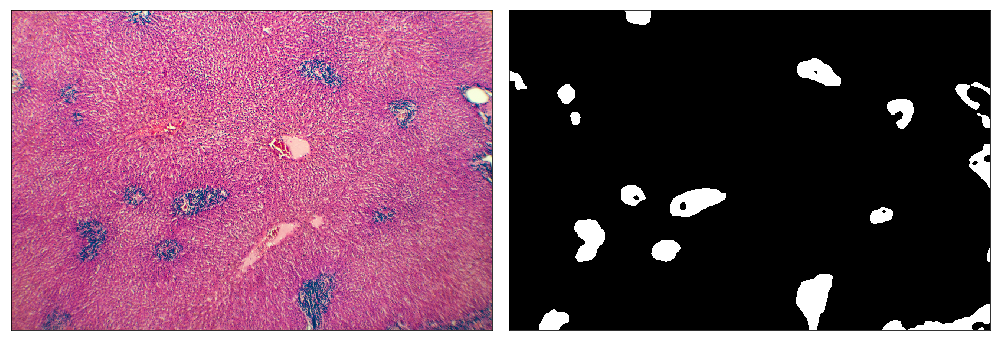

In [8]:
# Apply an adaptive threshold
thresholded = contrast > filters.threshold_local(contrast, 351, offset=-0.1)

plot_image(np.dstack((image, thresholded)))

We now have something that matches fairly well. However, the contours of the inflammatory zones aren't very "natural", and the zones contain holes. We can clean this up using some morphological operations.

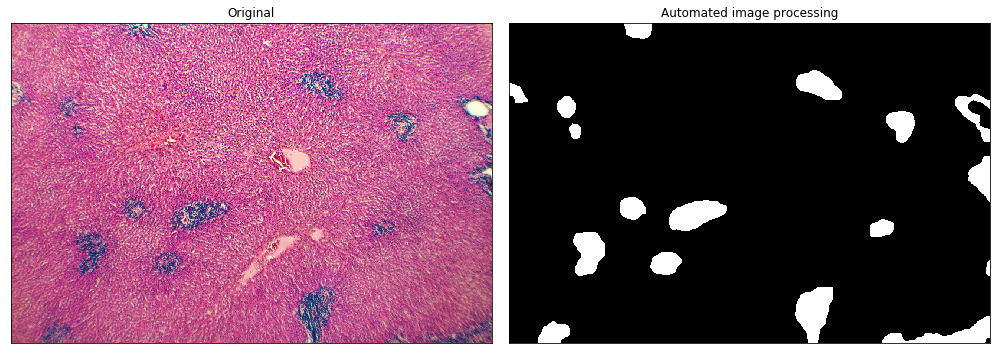

In [9]:
# Use a maximum filter followed by a binary closing to fill any holes
enlarged = maximum_filter(thresholded, 5)
inflammation = morphology.closing(enlarged, morphology.disk(11))

plot_image(np.dstack((image, inflammation)), titles=["Original", "Automated image processing"])

### Let's compare with our human expert's mask.

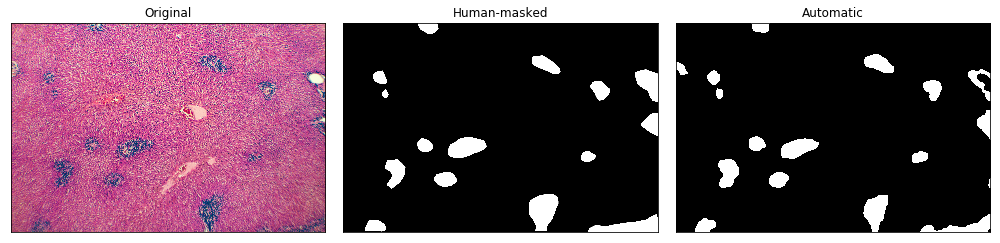

In [10]:
# Load up the human mask and visualise everything together
mask = transform.rescale(io.imread("data/Sheep11-4x-77.jpg_mask.jpg"), 0.25)
all_images = np.dstack((image, mask, inflammation))

plot_image(all_images, titles=["Original", "Human-masked", "Automatic"])

### Noisy data, and the need for robustness

<img src="talk/widefield.jpg" width="700px" />

### How does this algorithm perform ?

<img src="talk/results_widefield.jpg" width="800px" />

# Extension : a neural network approach

This is a quick experiment with a type of neural network called a convolutional encoder-decoder. They're some of the state-of-the-art neural network architectures for *semantic segmentation* : breaking down images into different parts, based on their content.

Over the weekend, I trained a ( very untuned ) convolutional encoder-decoder. Let's see what it can do.

In [11]:
# Let's use a convolutional encoder-decoder network to find inflammatory zones
from keras.models import load_model

model = load_model("models/histo_convnet.hdf5")
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 432, 648, 32)      896       
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 216, 324, 32)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 216, 324, 64)      18496     
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 216, 324, 64)      36928     
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 216, 324, 64)      36928     
__________

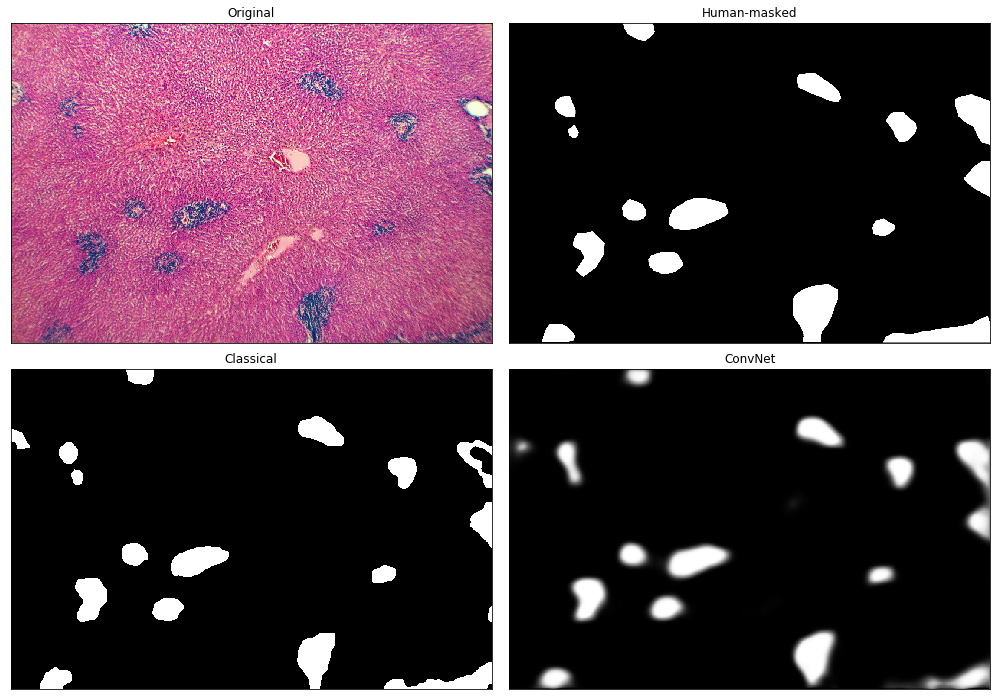

In [12]:
# Use the convnet to find the inflammatory zones, and compare with our work so far
nn_image = transform.rescale(image, 0.5)
pred = model.predict(nn_image.reshape(1, *nn_image.shape)).squeeze()

plot_grid((image, mask, inflammation, pred), ["Original", "Human-masked", "Classical", "ConvNet"])